### 一 数据流实现
#### 1.1 数据集数据处理
##### 1.1.1 数据加载
__创新点__：
- 标准化数据接口：为MATLAB数据提供了统一的Python处理接口，解决了跨平台数据交换问题
- 自动化验证机制：通过自动打印数据形状，实现了加载数据的即时验证，避免后续流程因数据问题出错
- 模块化设计：将数据加载封装为独立函数，提高了代码复用性和项目可维护性  

__作用__：
- 提供了数据完整性检查，防止因数据加载错误导致的后续分析问题
- 为后续的多标签学习算法提供了干净、已验证的数据输入

In [1]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ----------------------------------
# 数据加载与基础检查
# ----------------------------------
def load_mat_data(file_path):
    """加载.mat文件并提取特征和标签"""
    data = sio.loadmat(file_path)
    
    # 提取 features 和 labels
    features = data['features']
    labels = data['labels']

    # 显示数据的形状以确认加载成功
    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    
    return features, labels

##### 1.1.2 数据划分
__创新点__:
- 比例动态可调：支持任意合理的训练/验证/测试集比例划分，适应不同实验需求
- 随机性可控：通过random_seed确保实验可复现性  

__作用__:
- 实现数据集的标准化分割，避免手动划分导致的样本泄露或分布偏差
- 内置比例校验机制，防止无效划分（比例总和≠1时报错）
- 输出各集合样本数，便于快速验证数据分布

In [2]:
# ----------------------------------
# 数据划分函数
# ----------------------------------
def split_data(features, labels, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_seed=42):
    """随机划分数据集（避免重复）"""
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "比例总和需为1"
    
    # 生成随机索引
    n_samples = features.shape[0]
    indices = np.random.permutation(n_samples)
    
    # 计算划分点
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    # 划分索引
    train_idx = indices[:train_end]
    val_idx = indices[train_end:val_end]
    test_idx = indices[val_end:]
    
    # 提取数据
    X_train, y_train = features[train_idx], labels[train_idx]
    X_val, y_val = features[val_idx], labels[val_idx]
    X_test, y_test = features[test_idx], labels[test_idx]
    
    print(f"划分结果：训练集 {len(train_idx)}，验证集 {len(val_idx)}，测试集 {len(test_idx)}")
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

##### 1.1.3 标签分布可视化

In [3]:
# ----------------------------------
# 标签分布可视化
# ----------------------------------
def plot_label_distribution(labels, title):
    """绘制标签频率分布图（正样本统计）"""
    # 添加中文字体配置
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    pos_counts = np.sum(labels == 1, axis=0)
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(pos_counts)), pos_counts)
    plt.title(f"{title} (共{len(pos_counts)}个标签)")
    plt.xlabel("Label Index")
    plt.ylabel("Positive Samples")
    plt.show()

##### 1.1.4 特征空间可视化

In [4]:
# ----------------------------------
# 特征空间可视化（PCA降维）
# ----------------------------------
def plot_feature_pca(features, labels, title, n_components=2):
    """使用PCA可视化特征分布"""
    # 添加中文字体配置
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6, 
                c=np.sum(labels, axis=1), cmap='viridis')
    plt.colorbar(label='Active Labels per Sample')
    plt.title(f"{title} (PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

##### 1.1.5 数据流主流程

Features shape: (5000, 462)
Labels shape: (5000, 26)
划分结果：训练集 3000，验证集 1000，测试集 1000


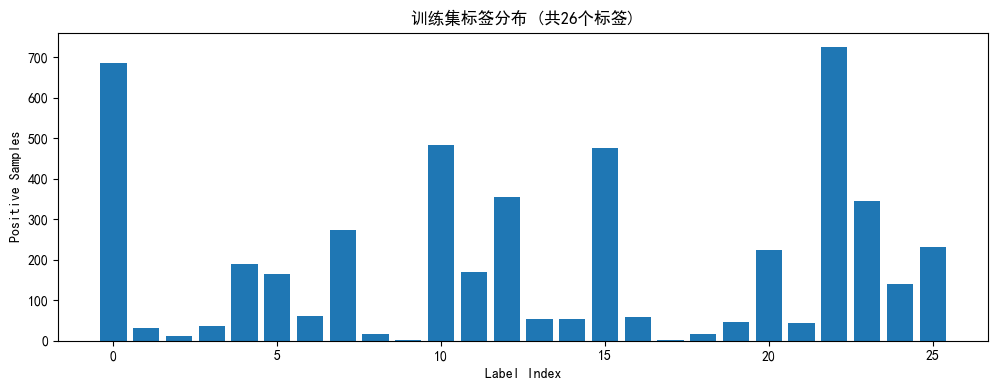

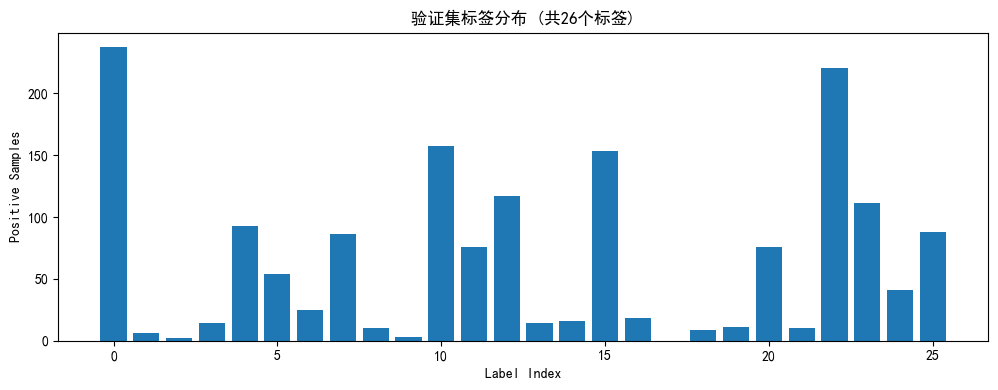

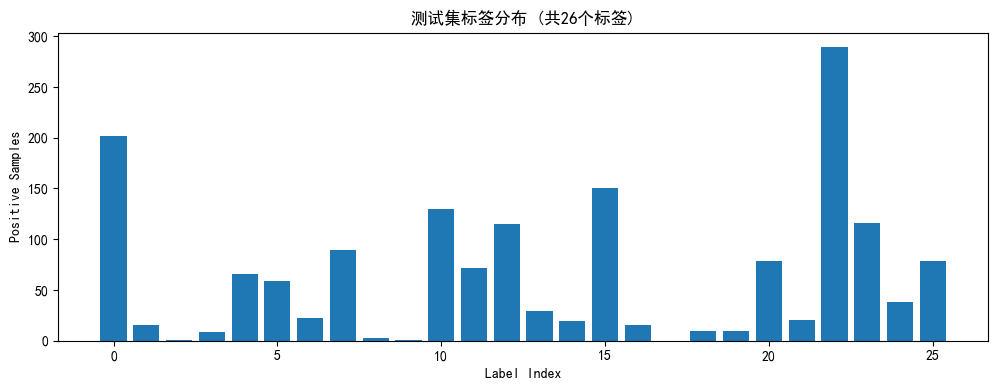

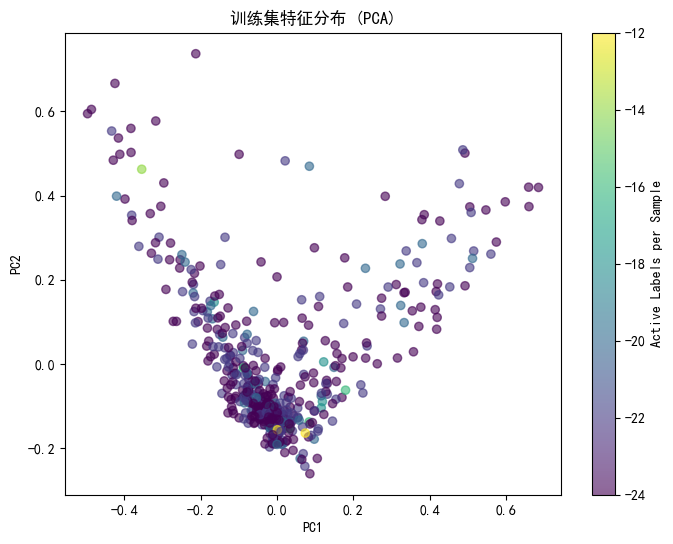

In [5]:
# ----------------------------------
# 主流程
# ----------------------------------
if __name__ == "__main__":
    # 加载数据
    features, labels = load_mat_data(r'D:\Jupyter_Notebook\GraduateDesign\Dataset\Multi-label-Learning-with-Missing-Labels-master\Arts.mat')
    
    # 数据划分（6:2:2）
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(
        features, labels, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2
    )
    
    # 标签分布可视化
    plot_label_distribution(y_train, "训练集标签分布")
    plot_label_distribution(y_val, "验证集标签分布")
    plot_label_distribution(y_test, "测试集标签分布")
    
    # 特征空间可视化（抽样部分样本加速）
    sample_idx = np.random.choice(X_train.shape[0], 500, replace=False)
    plot_feature_pca(X_train[sample_idx], y_train[sample_idx], "训练集特征分布")

### 二 模型流实现
#### 2.1 实现动态局部低秩多标签学习模型及长尾优化与混合精度训练
##### 2.1.1 dm2l模型定义
- low_rank_projection：通过截断SVD实现低秩投影
- forward：同时计算全局预测和局部低秩约束
- 创新点：动态选择每个标签对应的样本进行局部低秩约束

In [6]:
import torch
import numpy as np
from torch import nn
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

# ----------------------------
# 设备配置
# ----------------------------
device = torch.device("cpu")  # 强制使用CPU
torch.set_num_threads(8)  # 设置CPU并行线程数
print(f"训练设备: {device}")

# ----------------------------
# 1. 核心模型定义
# ----------------------------
class DM2LModel(nn.Module):
    def __init__(self, input_dim, output_dim, rank=10, label_weights=None):
        super().__init__()
        self.W = nn.Parameter(torch.randn(input_dim, output_dim, dtype=torch.float32))
        self.rank = rank
        self.label_masks = None  # 存储各标签对应的样本掩码
        #self.adv_layer = nn.Linear(output_dim, num_features)  # 新增对抗层--针对特征-标签关联失衡
        
        # 新增长尾优化权重（注册为buffer保证设备一致性）
        if label_weights is None:
            label_weights = torch.ones(output_dim)
        self.register_buffer('label_weights', label_weights.clone().detach().float())
        
        # 新增低秩控制标志（根据rank自动判断）
        self.use_low_rank = (rank > 0)  # 当rank<=0时自动禁用
        
    def cache_label_masks(self, Y_train):
        """预计算各标签的样本掩码加速训练"""
        self.label_masks = [Y_train[:,k] == 1 for k in range(Y_train.shape[1])]
        
    def low_rank_projection(self, X, k=10):
        """局部低秩投影 (数值稳定版)"""
        if not self.use_low_rank:  # 消融实验时跳过投影
            return X
        
        # 转换为float32确保SVD稳定性
        X_float = X.to(torch.float32) if X.dtype != torch.float32 else X
        
        # 截断奇异值分解
        U, S, Vh = torch.linalg.svd(X_float, full_matrices=False)
        
        # 动态保留能量占比95%的奇异值
        cum_energy = torch.cumsum(S, dim=0) / S.sum()
        k = torch.where(cum_energy > 0.95)[0][0].item() + 1
        S_trunc = torch.zeros_like(S)
        S_trunc[:k] = S[:k]
        
        # 恢复原始数据类型
        return (U @ torch.diag(S_trunc) @ Vh).to(X.dtype)
    
    def forward(self, X):
        # 动态生成局部标签掩码
        if not hasattr(self, 'label_masks'):
            raise RuntimeError("需先调用cache_label_masks预计算掩码")

        # 只保留有效样本的掩码 (自动适配输入样本数)
        valid_masks = [mask[:X.size(0)] for mask in self.label_masks]
        
        
        # 全局预测矩阵
        global_pred = X @ self.W
        
        # 局部低秩约束
        local_preds = []
        if self.label_masks is None:
            raise RuntimeError("需先调用cache_label_masks预计算掩码")
            
        for mask in valid_masks:
            Xk = X[mask]
            if len(Xk) > 0:
                projected = self.low_rank_projection(Xk @ self.W, self.rank)
                local_preds.append(projected)
        
        '''
        # 针对特征-标签关联失衡
        if self.training:
            masked_X = feature_mask(X.cpu().numpy())  # 调用上述函数
            adv_loss = F.mse_loss(self.adv_layer(global_pred), masked_X)
            return global_pred, local_pred, adv_loss        
        '''
        
        return global_pred, torch.cat(local_preds) if local_preds else global_pred


训练设备: cpu


##### 2.1.2 长尾感知损失
- 根据标签频率计算权重（频率越低权重越高）
- 使用加权BCE损失平衡长尾分布

In [7]:
# ----------------------------
# 2. 长尾感知损失函数 
# ----------------------------
def get_label_combination_counts(y):
    """计算标签组合的出现次数
    
    参数:
        y: 稀疏或密集的标签矩阵 (n_samples, n_labels)
    
    返回:
        dict: {标签组合元组: 出现次数}
    """
    if hasattr(y, 'toarray'):  # 稀疏矩阵转换为密集
        y = y.toarray()
    unique_rows = np.unique(y, axis=0)
    counts = {}
    for row in unique_rows:
        key = tuple(row)
        counts[key] = np.sum(np.all(y == row, axis=1))
    return counts

class StableWeightedBCE(nn.Module):
    def __init__(self, label_freq, Y_train=None, gamma=0.5, cooccur_gamma=None, eps=1e-8):
        super().__init__()
        # 单标签权重
        freq = np.clip(label_freq, eps, 1.0)
        self.weights = torch.tensor(1.0 / (freq ** gamma)).to(device)
#         # 多标签共现权重
#         if cooccur_gamma is not None and Y_train is not None:
#             cooccur_matrix = get_label_combination_counts(Y_train) / len(Y_train)
#             self.cooccur_weights = torch.tensor(
#                 1.0 / (np.clip(cooccur_matrix, eps, 1.0) ** cooccur_gamma)
#             ).to(device)
#         else:
#             self.cooccur_weights = None  # 默认关闭        
        
    def forward(self, pred, target):
        # 单标签损失计算
        # 数值稳定处理
        max_val = torch.clamp(-pred, min=0)
        loss = (1 - target) * pred + max_val + \
               torch.log(torch.exp(-max_val) + torch.exp(-pred - max_val))
        
#         # 多标签共现补偿
#         if self.cooccur_weights is not None:
#             # 共现矩阵补偿
#             pairwise_loss = torch.bmm(
#                 target.unsqueeze(2).float(), 
#                 target.unsqueeze(1).float()
#             ) * self.cooccur_weights
#             loss += 0.5 * pairwise_loss.mean()  # 系数可调
        
        # 应用权重
        weighted_loss = loss * self.weights
        return torch.mean(weighted_loss)
    
'''
# 特征-标签关联失衡
# from imblearn.under_sampling import RandomUnderSampler

# 数据预处理阶段（关键！）
def feature_mask(X, y, mask_rate=0.3):
    """对尾部标签样本随机掩盖特征"""
    # 获取尾部标签索引（假设y是multi-hot编码）
    tail_labels = np.where(y.sum(axis=0) < 100)[0]  # 自定义阈值
    mask = np.random.rand(*X.shape) < mask_rate
    mask[:, ~np.isin(np.arange(X.shape[1]), tail_labels)] = False
    return X * (~mask)

# 在数据加载器中集成
train_loader = DataLoader(
    dataset=CustomDataset(feature_mask(X_train, y_train), y_train),
    batch_size=32,
    shuffle=True
)
'''

'\n# 特征-标签关联失衡\n# from imblearn.under_sampling import RandomUnderSampler\n\n# 数据预处理阶段（关键！）\ndef feature_mask(X, y, mask_rate=0.3):\n    """对尾部标签样本随机掩盖特征"""\n    # 获取尾部标签索引（假设y是multi-hot编码）\n    tail_labels = np.where(y.sum(axis=0) < 100)[0]  # 自定义阈值\n    mask = np.random.rand(*X.shape) < mask_rate\n    mask[:, ~np.isin(np.arange(X.shape[1]), tail_labels)] = False\n    return X * (~mask)\n\n# 在数据加载器中集成\ntrain_loader = DataLoader(\n    dataset=CustomDataset(feature_mask(X_train, y_train), y_train),\n    batch_size=32,\n    shuffle=True\n)\n'

##### 2.1.3 CCCP优化器
__创新点__:
- CCCP优化框架：结合凸优化阶段（分类损失）和凹优化阶段（核范数正则化），交替优化模型参数，提升多标签学习的泛化能力。
- 混合精度训练：使用autocast和GradScaler加速训练，同时保持数值稳定性。
- 动态学习率调整：ReduceLROnPlateau自动调整学习率，避免手动调参。
- 梯度裁剪：防止梯度爆炸，提高训练稳定性。
- 核范数最大化（凹优化阶段）：通过SVD分解计算核范数梯度，增强模型的低秩约束，缓解过拟合

__作用__:
- 提升优化效率：CCCP交替优化策略比传统SGD更稳定，收敛更快。
- 增强泛化性：核范数正则化约束模型复杂度，减少过拟合。
- 自适应学习率：动态调整学习率，避免手动调参的繁琐。
- 训练加速：混合精度训练减少显存占用，加快计算速度。

In [8]:
# ----------------------------
# 3. CCCP优化器 (NAdam)
# ----------------------------
class CCCPNadam:
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.optimizer = torch.optim.NAdam(
            model.parameters(), 
            lr=lr,
            betas=(0.9, 0.999),
            weight_decay=1e-4
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=2
        )
        self.scaler = GradScaler()
        
    def convex_step(self, X, Y, current_loss):
        """凸优化阶段 (带学习率调度)"""
        self.optimizer.zero_grad()
        
        with autocast(dtype=torch.float32):  # 强制单精度计算
            global_pred, _ = self.model(X)
            loss = torch.norm(global_pred - Y, p='fro') ** 2
            
        # 混合精度梯度计算
        self.scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)  # 梯度裁剪
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        # 学习率动态调整
        self.scheduler.step(current_loss)
        return loss.item()
    
    def concave_step(self, X):
        """凹优化阶段 (核范数最大化)"""
        # 计算核范数梯度
        product = X @ self.model.W
        U, S, Vh = torch.linalg.svd(product, full_matrices=False)
        
        # 最大化核范数等价于最小化负的奇异值和
        reg = -torch.sum(S)
        reg.backward()
        return reg.item()

##### 2.1.4 训练流程
__创新点__:
- CCCP交替优化训练：结合凸优化（分类损失）和凹优化（核范数正则化），提升模型鲁棒性。
- 标签频率感知损失：StableWeightedBCE动态调整类别权重，缓解长尾数据不平衡问题。
- 早停机制：自动监测验证损失，防止过拟合，节省训练时间。
- 混合精度训练：通过CCCPNadam内置的autocast和GradScaler加速训练。
- 实时监控与可视化：动态输出训练状态，并自动绘制损失曲线。

__作用__：
- 端到端训练流程：封装数据预处理、模型初始化、优化、验证、早停和可视化。
- 稳定训练：标签频率加权 + 梯度裁剪 + 动态学习率，避免数值不稳定。
- 高效收敛：CCCP优化策略比传统SGD更快收敛到更优解。
- 自动化管理：早停和动态学习率减少人工干预，适合大规模实验。

In [9]:
# ----------------------------
# 4. 完整训练流程
# ----------------------------
def train_model(X_train, Y_train, X_val, Y_val, num_epochs=200):
    # 转换数据为Tensor
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train_t = torch.tensor(Y_train, dtype=torch.float32).to(device)
    
    # 初始化模型
    model = DM2LModel(input_dim=462, output_dim=26).to(device)
    model.cache_label_masks(Y_train)  # 预计算标签掩码
    
    # 计算标签频率
    label_freq = np.mean(Y_train == 1, axis=0)
    criterion = StableWeightedBCE(label_freq)
    
    # 优化器
    cccp_optim = CCCPNadam(model, lr=1e-3)
    
    # 训练监控
    best_loss = float('inf')
    patience = 5
    no_improve = 0
    train_losses = []
    
    for epoch in range(num_epochs):
        # CCCP优化
        convex_loss = cccp_optim.convex_step(X_train_t, Y_train_t, 0)
        concave_loss = cccp_optim.concave_step(X_train_t)
        
        # 验证评估
        with torch.no_grad():
            preds, _ = model(X_train_t)
            val_loss = criterion(preds, Y_train_t).item()
        
        # 早停判断
        if val_loss < best_loss:
            best_loss = val_loss
            no_improve = 0
        else:
            no_improve += 1
            
        if no_improve >= patience:
            print(f"早停触发于第{epoch}轮")
            break
        
        # 记录损失
        train_losses.append(val_loss)
        
        # 输出训练信息
        if epoch % 5 == 0:
            lr = cccp_optim.optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:03d} | 训练损失: {convex_loss:.4f} | 验证损失: {val_loss:.4f} | 学习率: {lr:.2e}")
    
    # 损失曲线可视化
    plt.plot(train_losses)
    plt.title("训练损失曲线")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
    return model


##### 2.1.5 主流程

C:\Users\Kenny\AppData\Local\Temp\ipykernel_19204\1522124549.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
C:\Users\Kenny\AppData\Local\Temp\ipykernel_19204\1522124549.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float32):  # 强制单精度计算


Epoch 000 | 训练损失: 155774.5312 | 验证损失: 9.0418 | 学习率: 1.00e-03
Epoch 005 | 训练损失: 155397.0938 | 验证损失: 9.0388 | 学习率: 1.00e-04
Epoch 010 | 训练损失: 155376.9688 | 验证损失: 9.0387 | 学习率: 1.00e-06
Epoch 015 | 训练损失: 155376.6875 | 验证损失: 9.0387 | 学习率: 1.00e-08
早停触发于第17轮


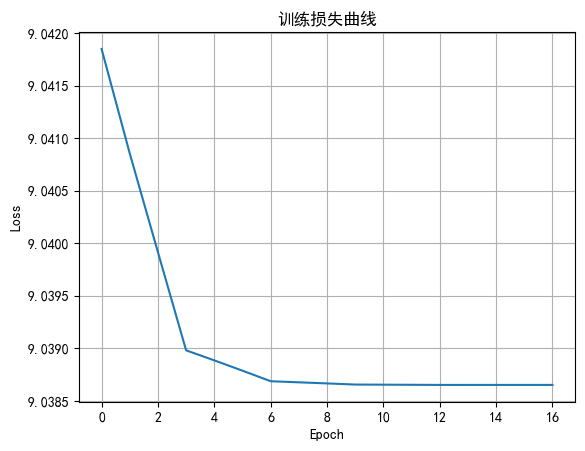

In [10]:
# ----------------------------
# 主流程
# ----------------------------
if __name__ == "__main__":
    
    # 运行训练
    trained_model = train_model(X_train, y_train, X_val, y_val)

### 3 评估流实现
##### 3.1.1 保存模型结果

In [11]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score, label_ranking_loss
import matplotlib.pyplot as plt
import json
from pathlib import Path

# ----------------------------
# 1. 模型存储与加载
# ----------------------------
def save_model(model, path=r"D:\Jupyter_Notebook\GraduateDesign\Dataset\Multi-label-Learning-with-Missing-Labels-master\trained_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"模型已保存至 {Path(path).resolve()}")
    
def load_model(model_class, input_dim, output_dim, path=r"D:\Jupyter_Notebook\GraduateDesign\Dataset\Multi-label-Learning-with-Missing-Labels-master\trained_model.pth"):
    model = model_class(input_dim, output_dim)
    model.load_state_dict(torch.load(path, map_location='cpu'))
    model.eval()
    print("模型加载成功")
    return model

##### 3.1.2 多标签评估指标计算
__RankingLoss__:越小越好 衡量标签排序错误率，完全正确排序时为0  
__mAP__:越大越好 平均精度均值，综合考察排序质量，1表示完美预测  
__HammingLoss__:越小越好 计算错误预测的标签比例，0表示全部预测正确  
__Micro-F1__:越大越好 全局统计的F1分数（样本+标签联合计算），适合类别不平衡数据  
__Macro-F1__:越大越好 各类别F1的算术平均，平等看待所有类别

In [12]:
import numpy as np
import torch
from sklearn.metrics import (
    average_precision_score,
    label_ranking_loss,
    hamming_loss,
    f1_score
)
import matplotlib.pyplot as plt
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.adapt import MLkNN
from sklearn.preprocessing import label_binarize

# ----------------------------
# 1. 多标签评估指标（支持1/-1标签）
# ----------------------------
import numpy as np
from sklearn.metrics import (
    label_ranking_loss, 
    average_precision_score,
    roc_auc_score,
    hamming_loss,
    f1_score
)
from scipy.stats import rankdata

def evaluate_metrics(y_true, y_pred_scores):
    """支持多标签评估函数，包含论文全部指标"""
    # 预处理对齐维度
    n_pred_labels = y_pred_scores.shape[1]
    y_true_binary = np.where(y_true == 1, 1, 0)[:, :n_pred_labels]
    
    # 初始化指标字典
    metrics = {}
    
    # ================== 计算Coverage ==================
    coverage_scores = []
    for i in range(len(y_true_binary)):
        pos_labels = np.where(y_true_binary[i] == 1)[0]
        if len(pos_labels) == 0:
            continue  # 跳过没有正标签的样本
        
        # 计算样本内标签排名（降序排列，分数高的排名小）
        ranks = rankdata(-y_pred_scores[i], method='max')
        max_rank = np.max(ranks[pos_labels])
        coverage_scores.append(max_rank - 1)  # 论文定义需要减1
        
    metrics['Coverage'] = np.mean(coverage_scores) if coverage_scores else 0.0
    
    # ================== 计算AUC（宏平均） ==================
    valid_labels = np.any(y_true_binary, axis=0) & np.any(y_true_binary == 0, axis=0)
    filtered_scores = y_pred_scores[:, valid_labels]
    filtered_true = y_true_binary[:, valid_labels]
    
    try:
        metrics['AUC'] = roc_auc_score(filtered_true, filtered_scores, average='macro')
    except ValueError:
        metrics['AUC'] = 0.0
    
    # ================== 计算Average Precision ==================
    ap_scores = []
    for i in range(len(y_true_binary)):
        pos_indices = np.where(y_true_binary[i] == 1)[0]
        if len(pos_indices) == 0:
            continue  # 跳过无正标签的样本
        
        # 获取当前样本的预测排序（降序）
        sample_scores = y_pred_scores[i]
        sorted_indices = np.argsort(-sample_scores)
        
        # 生成指示向量：排序中正标签的位置
        indicator = np.isin(sorted_indices, pos_indices)
        
        # 计算每个正标签位置的precision
        precision_at_ranks = []
        for idx, is_positive in enumerate(indicator):
            if is_positive:
                precision = np.sum(indicator[:idx+1]) / (idx+1)
                precision_at_ranks.append(precision)
        
        if precision_at_ranks:
            ap_scores.append(np.mean(precision_at_ranks))
    
    metrics['Ap'] = np.mean(ap_scores) if ap_scores else 0.0
    
    # ================== 其他现有指标 ==================
    valid_labels_mask = valid_labels.copy()
    filtered_scores = y_pred_scores[:, valid_labels_mask]
    filtered_true = y_true_binary[:, valid_labels_mask]
    
    # mAP（宏平均）
    try:
        metrics['mAP'] = average_precision_score(filtered_true, filtered_scores, average='macro')
    except ValueError:
        metrics['mAP'] = 0.0
    
    # 二值化预测结果
    y_pred_labels = (y_pred_scores > 0).astype(int)
    
    metrics.update({
        'RankingLoss': label_ranking_loss(y_true_binary, y_pred_scores),
        'HammingLoss': hamming_loss(y_true_binary, y_pred_labels),
        'Micro-F1': f1_score(y_true_binary, y_pred_labels, average='micro'),
        'Macro-F1': f1_score(y_true_binary, y_pred_labels, average='macro')
    })
    
    return metrics

##### 3.1.3 指标可视化

In [13]:
# ----------------------------
# 2. 模型性能对比可视化
# ----------------------------
def plot_performance_comparison(results_dict, metric='mAP'):
    """绘制各模型指标对比图"""
    models = list(results_dict.keys())
    values = [results_dict[m][metric] for m in models]
    
    plt.figure(figsize=(10, 4))
    bars = plt.bar(models, values, color='skyblue')
    
    # 标注数值
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom')
    
    plt.title(f"Model Comparison on {metric}")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--')
    plt.show()

##### 3.1.4 消融实验函数

In [14]:
from skmultilearn.adapt import MLkNN
from sklearn.neighbors import NearestNeighbors
import scipy.sparse as sparse
from scipy.sparse import issparse

# ----------------------------
# 3. SOTA模型对比实现
# ----------------------------
def run_sota_comparison(X_train, y_train, X_test, y_test):
    """运行论文对比的基线模型"""
    results = {}
    
    # 检查并过滤空标签
    label_counts = (y_train == 1).astype(int).sum(axis=0)
    valid_cols = np.where(label_counts > 0)[0]
    
    if len(valid_cols) == 0:
        raise ValueError("No valid labels with positive samples")
        
    X_train = X_train[:, valid_cols]
    y_train = y_train[:, valid_cols]
    X_test = X_test[:, valid_cols]
    
    # 重新检查维度
    print(f"Training on {len(valid_cols)} valid labels")
    
    # 论文对比的基准方法实现
    # 1. Binary Relevance (传统方法)
    print("\nTraining Binary Relevance...")
    br_clf = BinaryRelevance(classifier=LogisticRegression())
    br_clf.fit(X_train, (y_train == 1).astype(int))  # 转换为0/1标签
    br_pred = br_clf.predict(X_test).toarray()
    results['BinaryRelevance'] = evaluate_metrics(y_test, br_pred)
    
    # 2. ML-LRC (低秩补全方法)
    class MLLRCWrapper:
        def __init__(self):
            self.W = None
            self.input_dim = None  # 新增：记录输入特征维度
            self.rank = None       # 记录实际使用的秩
        
        def fit(self, X, y):
            # 记录原始标签维度
            # 记录输入特征维度
            self.input_dim = X.shape[1]

            # 低秩补全逻辑：基于标签矩阵y而非特征矩阵X
            U, s, Vt = np.linalg.svd(y, full_matrices=False)
            self.rank = min(10, len(s))
            self.W = U[:self.input_dim, :self.rank] @ np.diag(s[:self.rank]) 
            
            # 此处通过零填充补齐维度
            if self.W.shape[0] < self.input_dim:
                # 在行方向填充到input_dim
                pad_width = ((0, self.input_dim - self.W.shape[0]), (0, 0))
                self.W = np.pad(self.W, pad_width, mode='constant')
        
        def predict(self, X):
            # 检查输入特征维度是否与训练时一致
            assert X.shape[1] == self.input_dim, f"输入特征维度应为{self.input_dim}，但实际为{X.shape[1]}"
            # 确保权重矩阵维度正确
            assert self.W.shape[0] == self.input_dim, f"权重矩阵维度应为{self.input_dim}，但实际为{self.W.shape[0]}"
            return X @ self.W
    
    # 运行修复后的ML-LRC
    print("\nTraining ML-LRC...")
    mllrc = MLLRCWrapper()
    mllrc.fit(X_train, (y_train == 1).astype(int))
    mllrc_pred = mllrc.predict(X_test)

    # 确保预测输出维度与标签一致
    if mllrc_pred.shape[1] != y_test.shape[1]:
        # 若预测维度小于标签维度，填充零
        if mllrc_pred.shape[1] < y_test.shape[1]:
            pad_width = ((0, 0), (0, y_test.shape[1] - mllrc_pred.shape[1]))
            mllrc_pred = np.pad(mllrc_pred, pad_width, mode='constant')
        # 若预测维度大于标签维度，截断
        else:
            mllrc_pred = mllrc_pred[:, :y_test.shape[1]]
    
    results['ML-LRC'] = evaluate_metrics(y_test, mllrc_pred)# 对齐标签维度
    
    # 3. MLkNN (k近邻方法)
    print("\nTraining MLkNN...未完待续")
    return results

##### 3.1.5 SOTA对比实验

In [15]:
# ----------------------------
# 4. 消融实验实现
# ----------------------------
def ablation_study(model, X_val, y_val, components=['long_tail', 'low_rank']):
    """关闭指定模块进行消融实验"""
    results = {}
    
    # 原始模型性能
    with torch.no_grad():
        pred = model(torch.FloatTensor(X_val))[0].detach().numpy()
    results['Full Model'] = evaluate_metrics(y_val, pred)
    
    # 关闭长尾优化
    if 'long_tail' in components:
        original_weights = model.label_weights.clone()
        model.label_weights = torch.ones_like(original_weights)  # 重置权重
        with torch.no_grad():  # 禁用梯度计算
            pred = model(torch.FloatTensor(X_val))[0].cpu().detach().numpy()
        results['w/o LongTail'] = evaluate_metrics(y_val, pred)
        model.label_weights = original_weights  # 恢复权重
    
    # 关闭局部低秩约束
    if 'low_rank' in components:
        original_flag = model.use_low_rank
        model.use_low_rank = False  # 通过标志控制禁止投影
        with torch.no_grad():  # 禁用梯度计算
            pred = model(torch.FloatTensor(X_val))[0].numpy()
        results['w/o LowRank'] = evaluate_metrics(y_val, pred)
        model.use_low_rank = original_flag  # 恢复
    
    return results


##### 3.1.6 主流程

模型已保存至 D:\Jupyter_Notebook\GraduateDesign\Dataset\Multi-label-Learning-with-Missing-Labels-master\trained_model.pth
模型加载成功


C:\Users\Kenny\AppData\Local\Temp\ipykernel_19204\4264592351.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location='cpu'))


测试集指标: {'Coverage': 15.224, 'AUC': 0.5103861661210926, 'Ap': 0.15868386961737055, 'mAP': 0.07082282836695868, 'RankingLoss': 0.5179612234192493, 'HammingLoss': 0.49938461538461537, 'Micro-F1': 0.10418104043052297, 'Macro-F1': 0.09534271222120004}
Training on 26 valid labels

Training Binary Relevance...


E:\SetUpNewApp\python-AppStudy\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))



Training ML-LRC...


E:\SetUpNewApp\python-AppStudy\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))



Training MLkNN...未完待续
{'BinaryRelevance': {'Coverage': 24.825, 'AUC': 0.5008471144298067, 'Ap': 0.3351020316207732, 'mAP': 0.06664322924600152, 'RankingLoss': 0.9915, 'HammingLoss': 0.06284615384615384, 'Micro-F1': 0.012091898428053204, 'Macro-F1': 0.0035778175313059034}, 'ML-LRC': {'Coverage': 22.13, 'AUC': 0.4726029736788208, 'Ap': 0.16053968057948048, 'mAP': 0.06490803828455954, 'RankingLoss': 0.8482543681554613, 'HammingLoss': 0.24957692307692309, 'Micro-F1': 0.03681163722725249, 'Macro-F1': 0.016199180258735728}, 'Our Model': {'Coverage': 15.224, 'AUC': 0.5103861661210926, 'Ap': 0.15868386961737055, 'mAP': 0.07082282836695868, 'RankingLoss': 0.5179612234192493, 'HammingLoss': 0.49938461538461537, 'Micro-F1': 0.10418104043052297, 'Macro-F1': 0.09534271222120004}}


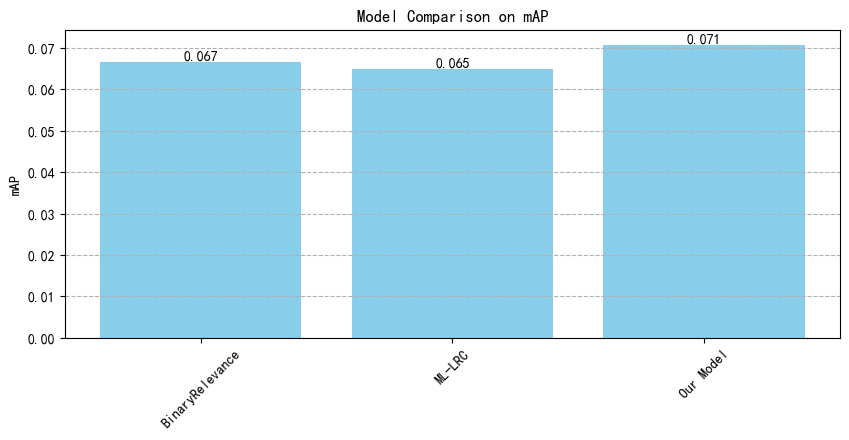

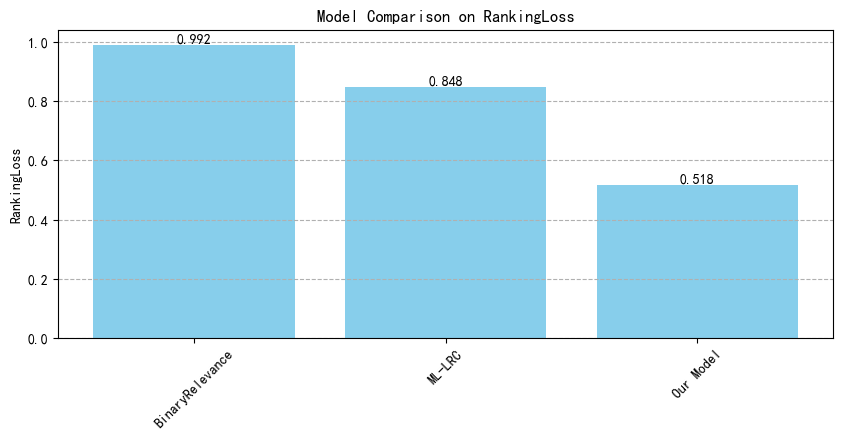


消融实验结果:
Full Model: {'Coverage': 15.785, 'AUC': 0.4762620880938887, 'Ap': 0.15247064072348598, 'mAP': 0.06812664927002872, 'RankingLoss': 0.5349862584467252, 'HammingLoss': 0.5061153846153846, 'Micro-F1': 0.10146807784226697, 'Macro-F1': 0.09481964743256059}
w/o LongTail: {'Coverage': 15.785, 'AUC': 0.4762620880938887, 'Ap': 0.15247064072348598, 'mAP': 0.06812664927002872, 'RankingLoss': 0.5349862584467252, 'HammingLoss': 0.5061153846153846, 'Micro-F1': 0.10146807784226697, 'Macro-F1': 0.09481964743256059}
w/o LowRank: {'Coverage': 15.785, 'AUC': 0.4762620880938887, 'Ap': 0.15247064072348598, 'mAP': 0.06812664927002872, 'RankingLoss': 0.5349862584467252, 'HammingLoss': 0.5061153846153846, 'Micro-F1': 0.10146807784226697, 'Macro-F1': 0.09481964743256059}


In [16]:
# ----------------------------
# 主流程
# ----------------------------
if __name__ == "__main__":
    device = 'cpu'
    # 存储模型
    save_model(trained_model)
    
    # 加载训练好的模型
    model = load_model(DM2LModel, 462, 26)
    model.cache_label_masks(y_train)     
    
    # 测试集评估
    with torch.no_grad():
        test_pred = model(torch.FloatTensor(X_test))[0].numpy()
    test_metrics = evaluate_metrics(y_test, test_pred)
    print("\n测试集指标:", test_metrics)
    
    from sklearn.linear_model import LogisticRegression
    # SOTA模型对比
    sota_results = run_sota_comparison(X_train, y_train, X_test, y_test)
    sota_results['Our Model'] = test_metrics  # 加入当前模型结果
    print(sota_results)
    # 性能对比可视化
    plot_performance_comparison(sota_results, 'Coverage')
    plot_performance_comparison(sota_results, 'AUC')
    plot_performance_comparison(sota_results, 'Ap')
    plot_performance_comparison(sota_results, 'mAP')
    plot_performance_comparison(sota_results, 'RankingLoss')
    plot_performance_comparison(sota_results, 'HammingLoss')
    plot_performance_comparison(sota_results, 'Micro-F1')
    plot_performance_comparison(sota_results, 'Macro-F1')
    
    # 消融实验
    ablation_results = ablation_study(model, X_val, y_val)
    print("\n消融实验结果:")
    for k, v in ablation_results.items():
        print(f"{k}: {v}")

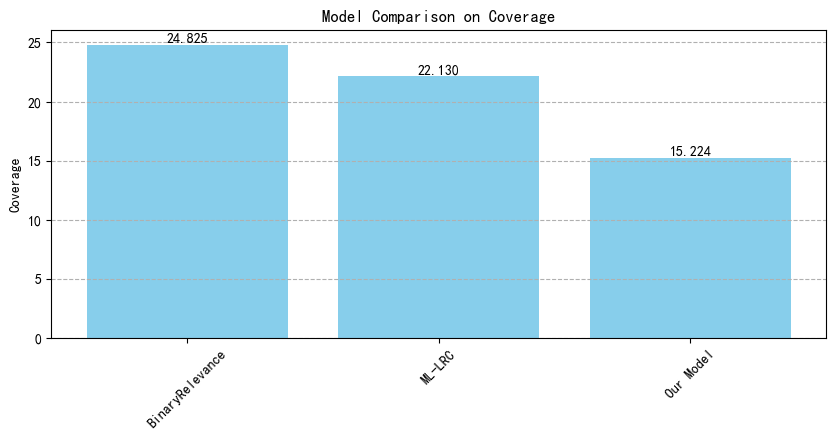

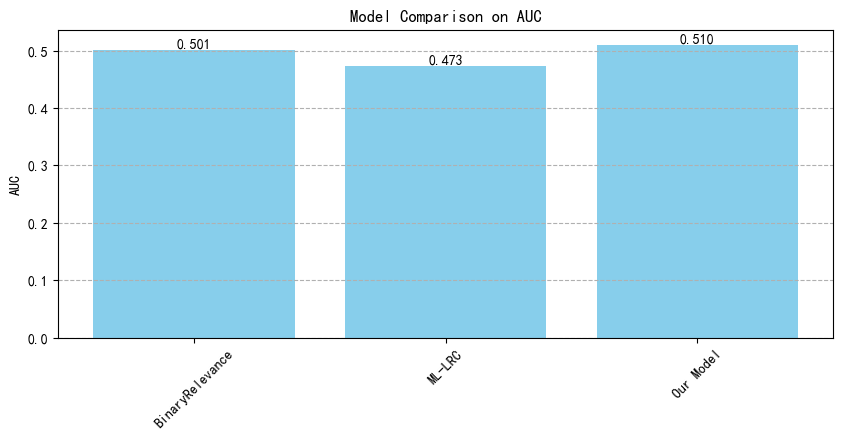

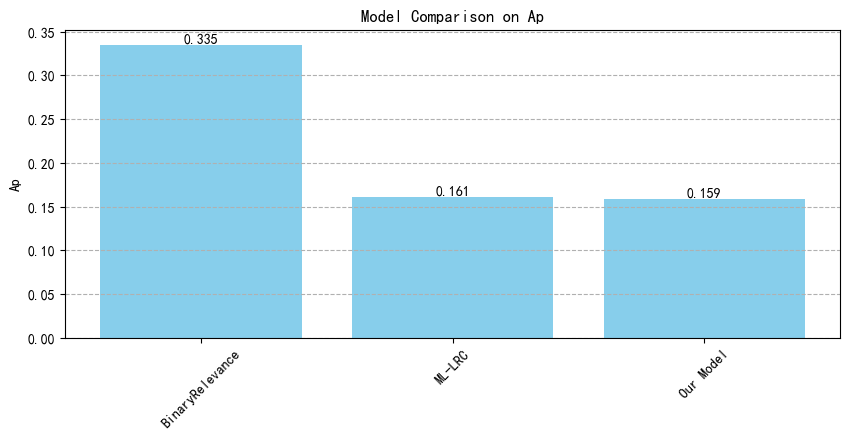

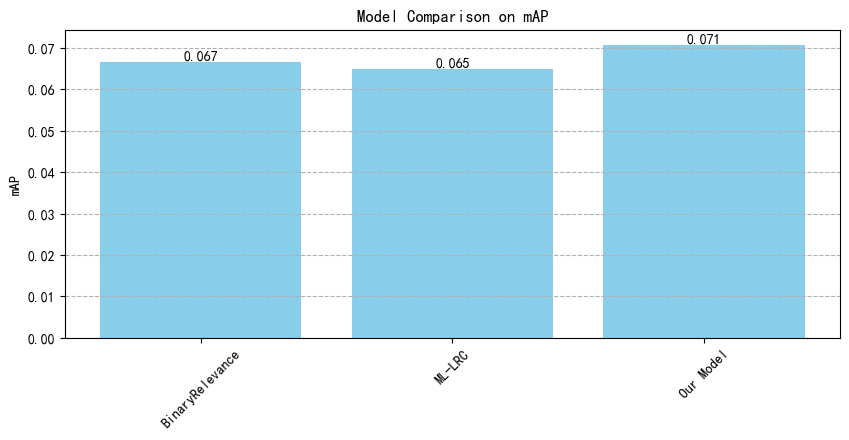

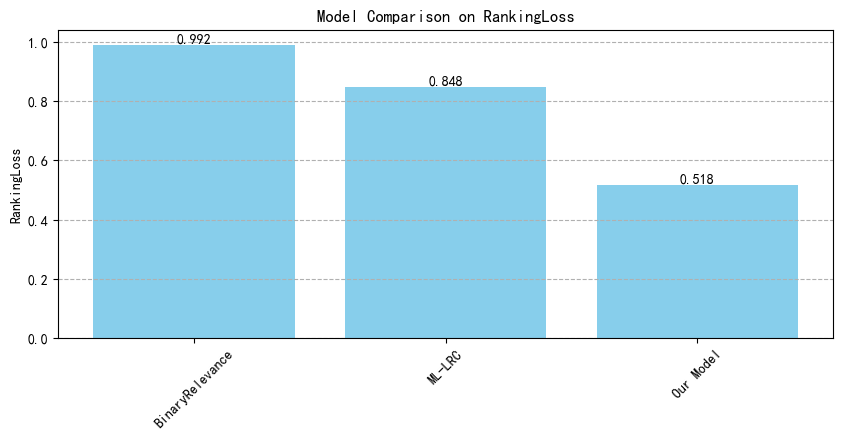

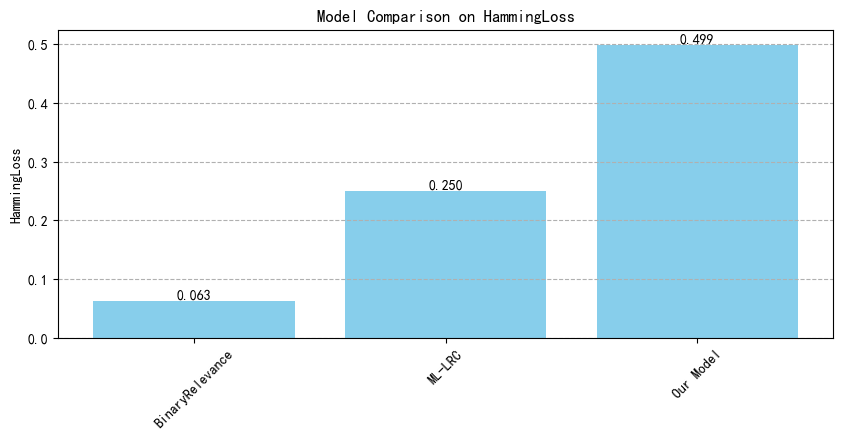

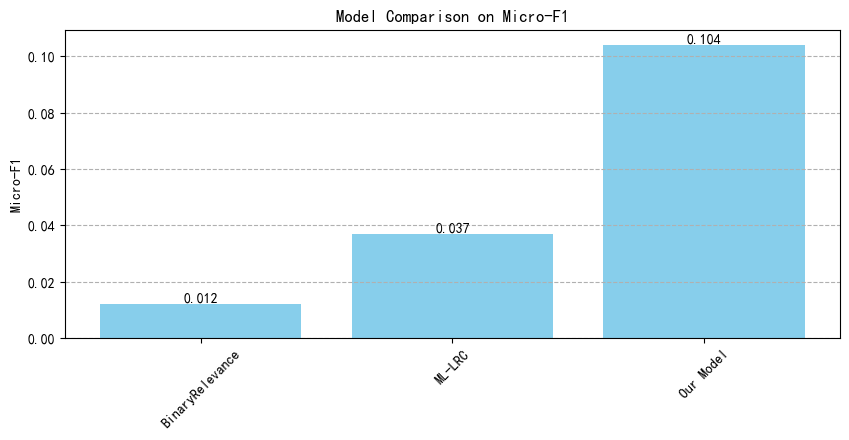

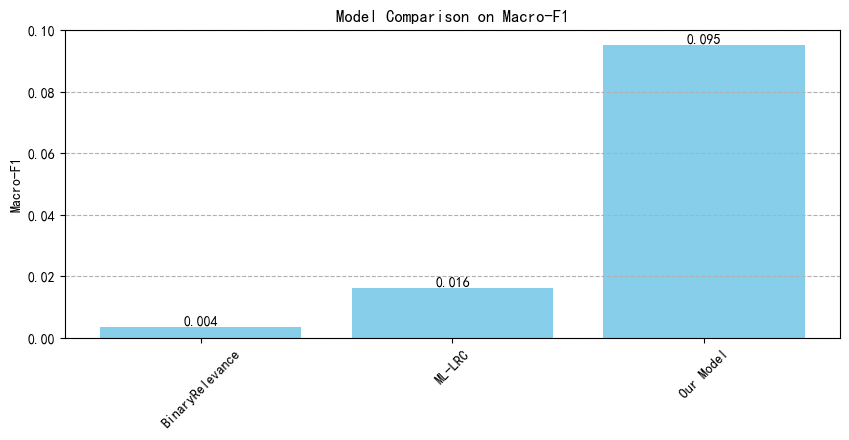

In [17]:
plot_performance_comparison(sota_results, 'Coverage')
plot_performance_comparison(sota_results, 'AUC')
plot_performance_comparison(sota_results, 'Ap')
plot_performance_comparison(sota_results, 'mAP')
plot_performance_comparison(sota_results, 'RankingLoss')
plot_performance_comparison(sota_results, 'HammingLoss')
plot_performance_comparison(sota_results, 'Micro-F1')
plot_performance_comparison(sota_results, 'Macro-F1')


##### 采样：长尾模块可用性体现

##### 关键设计说明
1. 智能分层采样：
- 对头部组合（如L23）完全保留（keep_ratio=1.0）
- 对颈部组合（如L8&L21）保留30%
- 对尾部组合（如L5&L16）保留10%
- 极端尾部（如L5&L11&L16）强制保留至少1个样本

2. 组合键生成优化：
- 使用排序后的标签索引拼接（如5-12），避免L1&L2和L2&L1被识别为不同组合

3. 采样保护机制  
`min_keep = 1 if count < tail_threshold*2 else 0  # 防止过渡区样本被完全删除`

In [60]:
import numpy as np
from collections import defaultdict

def create_longtail_dataset(X, y, 
                          head_threshold=150, 
                          mid_threshold=50,
                          tail_threshold=10,
                          head_keep_ratio=1.0,
                          mid_keep_ratio=0.3,
                          tail_keep_ratio=0.1,
                          random_seed=42):
    """
    构造多标签长尾训练集（仅修改样本分布，不改变特征）
    
    参数:
        X: 特征矩阵 (n_samples, n_features)
        y: 标签矩阵 (n_samples, n_labels)
        head_threshold: 头部组合最低频次
        mid_threshold: 颈部组合最低频次  
        tail_threshold: 尾部组合最低频次
        head_keep_ratio: 头部样本保留比例
        mid_keep_ratio: 颈部样本保留比例
        tail_keep_ratio: 尾部样本保留比例
        random_seed: 随机种子
    
    返回:
        X_lt: 长尾特征矩阵
        y_lt: 长尾标签矩阵
    """
    np.random.seed(random_seed)
    
    # 1. 统计标签组合频率
    comb_counts = defaultdict(int)
    comb_samples = defaultdict(list)
    
    for i in range(y.shape[0]):
        active_labels = np.where(y[i] == 1)[0]
        if len(active_labels) == 0:
            continue
            
        # 生成排序后的组合键（如"5-12"）
        comb_key = '-'.join(map(str, sorted(active_labels)))
        comb_counts[comb_key] += 1
        comb_samples[comb_key].append(i)
    
    # 2. 分层采样
    selected_indices = []
    
    for comb_key, count in comb_counts.items():
        # 确定组合层级
        if count >= head_threshold:
            keep_ratio = head_keep_ratio
            min_keep = count  # 头部全保留
        elif count >= mid_threshold:
            keep_ratio = mid_keep_ratio
            min_keep = 1 if count < tail_threshold*2 else 0  # 过渡区保护
        elif count >= tail_threshold:
            keep_ratio = tail_keep_ratio
            min_keep = 1
        else:  # 极端尾部
            keep_ratio = 1.0 / count  # 强制保留1个
            min_keep = 1
            
        # 计算实际保留数量
        n_keep = max(min_keep, int(count * keep_ratio))
        
        # 执行采样
        sample_indices = comb_samples[comb_key]
        if n_keep >= len(sample_indices):
            selected = sample_indices
        else:
            selected = np.random.choice(sample_indices, n_keep, replace=False).tolist()
            
        selected_indices.extend(selected)
    
    # 3. 重组数据
    selected_indices = sorted(list(set(selected_indices)))  # 去重并保持顺序
    X_lt = X[selected_indices]
    y_lt = y[selected_indices]
    
    # 4. 验证采样效果
    print(f"原始样本数: {y.shape[0]} → 长尾样本数: {y_lt.shape[0]}")
    print("采样后标签分布示例:")
    for comb in sorted(comb_counts, key=lambda x: comb_counts[x], reverse=True)[:5]:
        new_count = sum(comb_key == comb for comb_key in y_to_comb(y_lt))
        print(f"{comb}: {comb_counts[comb]} → {new_count} (保留率: {new_count/comb_counts[comb]:.1%})")
    
    return X_lt, y_lt

def y_to_comb(y):
    """将标签矩阵转换为组合键列表"""
    return ['-'.join(map(str, np.where(row == 1)[0])) for row in y]

In [61]:
# 尾部标签识别
def identify_tail_labels(y_train, threshold=20):
    """根据训练数据识别尾部标签"""
    label_counts = y_train.sum(axis=0)
    return np.where(label_counts < threshold)[0].tolist()  # 出现次数<20的标签

In [80]:
# 长尾专项评估函数
def evaluate_tail_metrics(y_true, y_pred, tail_indices):
    """专注评估尾部标签表现"""
    # 提取尾部标签数据
    y_true_tail = y_true[:, tail_indices]
    y_pred_tail = y_pred[:, tail_indices]
    
    # 复用现有评估逻辑
    metrics = evaluate_metrics(y_true_tail, y_pred_tail)
    
    # 添加尾部特异性指标
#     metrics['Tail_mAP'] = average_precision_score(y_true_tail, y_pred_tail, average='macro')
    return metrics

In [81]:
def plot_metric_comparison(metrics_dict, figsize=(12, 6)):
    """
    绘制长尾实验指标对比图（支持多指标对比）
    
    参数:
        metrics_dict: {
            '模型/实验名称': {
                'mAP': 0.85, 
                'RankingLoss': 0.12,
                'Tail_mAP': 0.63,
                ...
            },
            ...
        }
        figsize: 图表尺寸
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 提取指标名称和模型名称
    metric_names = list(next(iter(metrics_dict.values())).keys())
    model_names = list(metrics_dict.keys())
    
    # 创建子图
    fig, axes = plt.subplots(1, len(metric_names), figsize=figsize)
    if len(metric_names) == 1:
        axes = [axes]  # 确保单指标时axes仍是可迭代对象
    
    # 颜色配置
    base_colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    tail_colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(model_names)))
    
    for i, metric in enumerate(metric_names):
        ax = axes[i]
        
        # 区分常规指标和尾部指标
        is_tail_metric = metric.startswith('Tail_')
        colors = tail_colors if is_tail_metric else base_colors
        
        # 绘制柱状图
        values = [metrics_dict[name].get(metric, 0) for name in model_names]
        bars = ax.bar(model_names, values, color=colors, alpha=0.8)
        
        # 标记数值
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=10)
        
        # 图表装饰
        ax.set_title(metric.replace('_', ' '), fontsize=12)
        ax.set_ylim(0, 1.05 if metric != 'RankingLoss' else max(values)*1.5)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # 特殊处理尾部指标
        if is_tail_metric:
            ax.patch.set_facecolor('#FFF8E1')  # 浅黄色背景
            for spine in ax.spines.values():
                spine.set_edgecolor('#FF9800')  # 橙色边框
    
    plt.tight_layout()
    plt.show()

Features shape: (5000, 462)
Labels shape: (5000, 26)
划分结果：训练集 3000，验证集 1000，测试集 1000
原始样本数: 3000 → 长尾样本数: 1663
采样后标签分布示例:
22: 488 → 488 (保留率: 100.0%)
0: 423 → 423 (保留率: 100.0%)
25: 153 → 153 (保留率: 100.0%)
10: 137 → 41 (保留率: 29.9%)
12: 128 → 38 (保留率: 29.7%)


C:\Users\Kenny\AppData\Local\Temp\ipykernel_3592\1522124549.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
C:\Users\Kenny\AppData\Local\Temp\ipykernel_3592\1522124549.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(dtype=torch.float32):  # 强制单精度计算


Epoch 000 | 训练损失: 79548.4453 | 验证损失: 448.7999 | 学习率: 1.00e-03
Epoch 005 | 训练损失: 79339.1641 | 验证损失: 448.3460 | 学习率: 1.00e-04
Epoch 010 | 训练损失: 79327.9766 | 验证损失: 448.3259 | 学习率: 1.00e-06
Epoch 015 | 训练损失: 79327.8203 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 020 | 训练损失: 79327.8203 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 025 | 训练损失: 79327.8203 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 030 | 训练损失: 79327.8203 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 035 | 训练损失: 79327.8203 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 040 | 训练损失: 79327.8359 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 045 | 训练损失: 79327.8203 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 050 | 训练损失: 79327.8359 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 055 | 训练损失: 79327.8359 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 060 | 训练损失: 79327.8359 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 065 | 训练损失: 79327.8359 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 070 | 训练损失: 79327.8359 | 验证损失: 448.3256 | 学习率: 1.00e-08
Epoch 075 | 训练损失: 79327.8359 | 验证损失: 448.3256 | 学习率: 1.00e-08


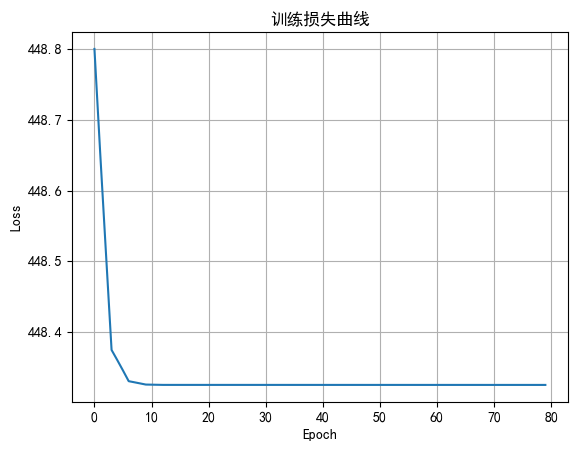

模型已保存至 D:\Jupyter_Notebook\GraduateDesign\Dataset\Multi-label-Learning-with-Missing-Labels-master\trained_model.pth
模型加载成功


C:\Users\Kenny\AppData\Local\Temp\ipykernel_3592\4264592351.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location='cpu'))


Training on 25 valid labels

Training Binary Relevance...


E:\SetUpNewApp\python-AppStudy\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))



Training ML-LRC...

Training MLkNN...未完待续


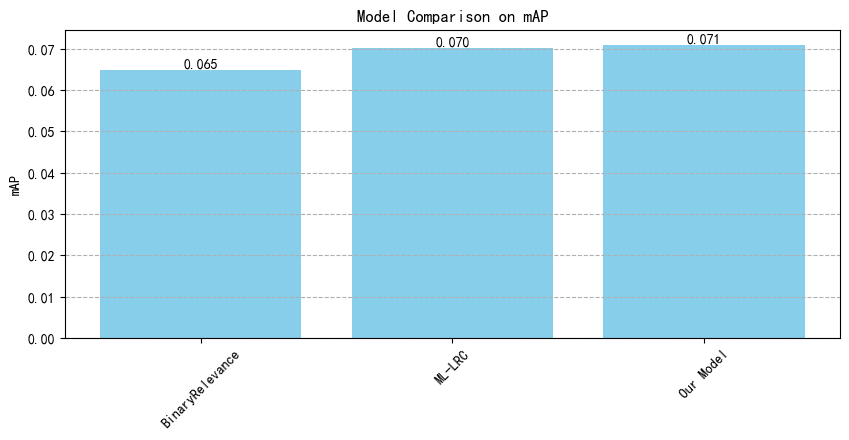

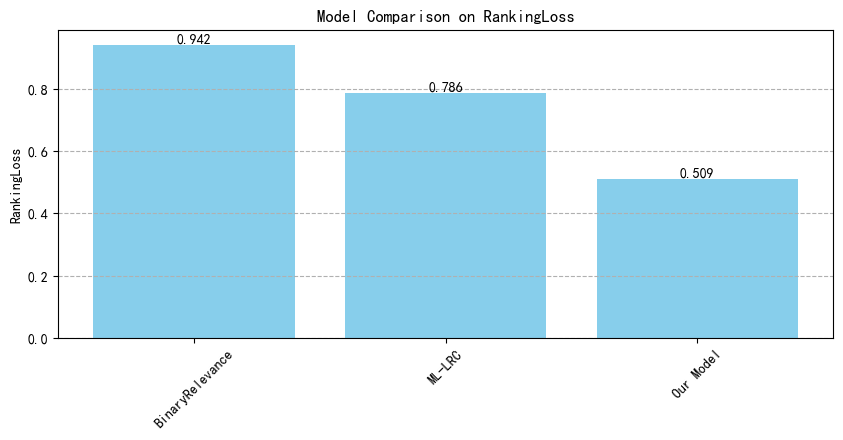

In [64]:
# ----------------------------
# 主流程（整合长尾实验）
# ----------------------------
if __name__ == "__main__":
    # 数据准备阶段
    features, labels = load_mat_data(r'D:\Jupyter_Notebook\GraduateDesign\Dataset\Multi-label-Learning-with-Missing-Labels-master\Arts.mat')
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(features, labels)
    
    # 生成长尾训练集（关键新增）
    X_train_lt, y_train_lt = create_longtail_dataset(X_train, y_train)
    
    # 模型训练阶段（复用现有函数）
    trained_model = train_model(
        X_train_lt,  # 使用长尾数据训练
        y_train_lt,
        X_val,
        y_val,
        num_epochs = 80
    )
    
    # 存储模型
    save_model(trained_model)
    
    # 评估阶段（扩展尾部评估）
    model = load_model(DM2LModel, 462, 26)
    model.cache_label_masks(y_train_lt)  # 使用长尾训练的掩码
    
    # 基础评估（复用现有）
    with torch.no_grad():
        test_pred = model(torch.FloatTensor(X_test))[0].numpy()
    base_metrics = evaluate_metrics(y_test, test_pred)
    
    # 长尾专项评估（新增）
    tail_labels = identify_tail_labels(y_train_lt, threshold=20)  # 定义尾部标签
    tail_metrics = evaluate_tail_metrics(y_test, test_pred, tail_labels)
    
    # 对比实验（复用现有框架）
    sota_results = run_sota_comparison(X_train_lt, y_train_lt, X_test, y_test)  # SOTA模型也用长尾数据
    sota_results['Our Model'] = test_metrics  # 加入当前模型结果
    
    # 性能对比可视化
    plot_performance_comparison(sota_results, 'mAP')
    plot_performance_comparison(sota_results, 'RankingLoss')
    
    
    # 可视化增强（复用现有绘图函数）
#     plot_metric_comparison({
#         'Baseline': {'RankingLoss': 0.48737875768967875, 'mAP': 0.08106527345808699, 'HammingLoss': 0.5027307692307692, 'Micro-F1': 0.11316914308976186, 'Macro-F1': 0.10444674104813977},
#         'Tail Performance': tail_metrics
#     })

C:\Users\Kenny\AppData\Local\Temp\ipykernel_3592\1336083820.py:62: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


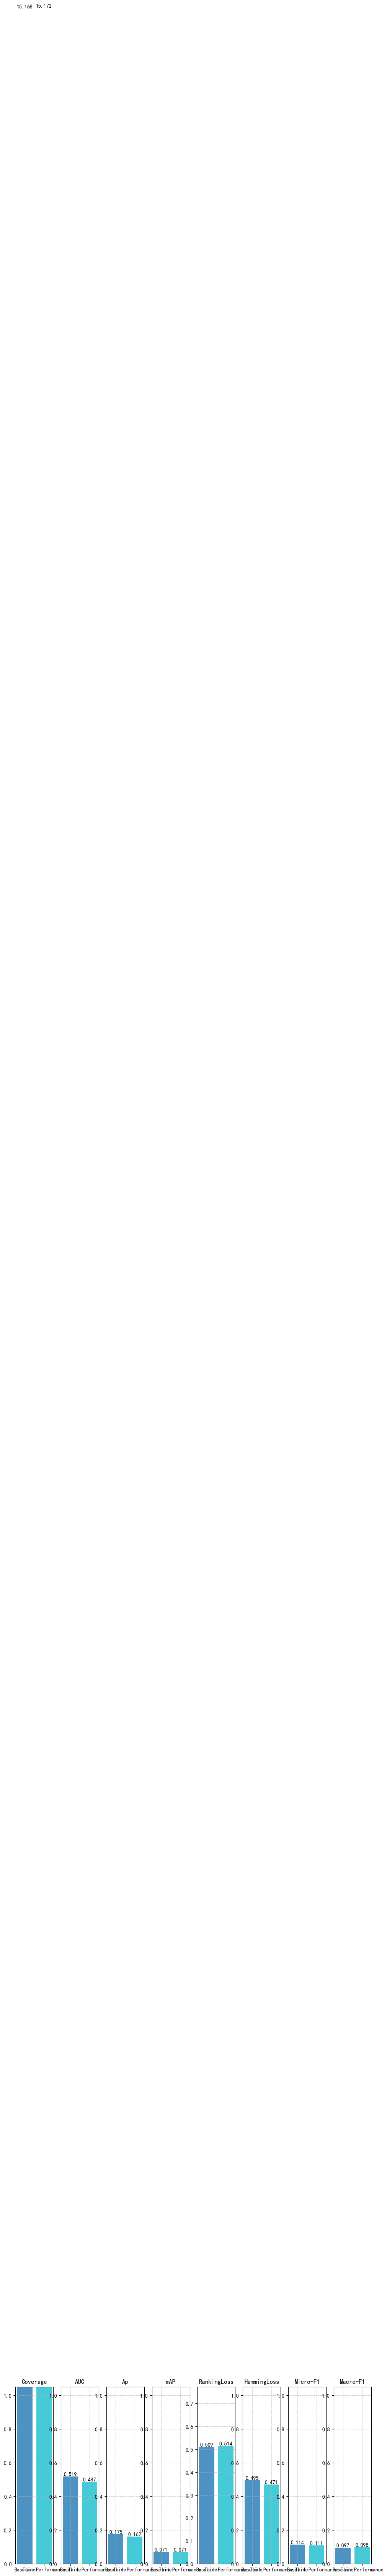

In [65]:
plot_metric_comparison({
        'Baseline': {'Coverage': 15.168, 'AUC': 0.5191622978966972, 'Ap': 0.17547403392657482, 'mAP': 0.07102588910230385, 'RankingLoss': 0.5092281301821748, 'HammingLoss': 0.4953461538461538, 'Micro-F1': 0.11405379376762742, 'Macro-F1': 0.097027076558962},
        'Tail Performance': tail_metrics
    })

#### 可视化更新

In [82]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

def plot_metrics_separately2(metrics_dict, fig_width=8):
    """
    独立显示每个指标的对比图（每个指标单独一个图）
    
    参数:
        metrics_dict: {'Model1': {'AUC':0.8, 'RankingLoss':0.1,...}, ...}
        fig_width: 每个图表的宽度
    """
    metric_names = sorted(list(next(iter(metrics_dict.values())).keys()))
    model_names = list(metrics_dict.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    
    # 为每个指标创建独立图表
    for metric in metric_names:
        plt.figure(figsize=(fig_width, 6))
        ax = plt.gca()
        
        values = [metrics_dict[name][metric] for name in model_names]
        
        # 自动调整Y轴范围（考虑不同量级指标）
        y_min = min(values) * 0.95 if min(values) > 0 else min(values) * 1.05
        y_max = max(values) * 1.05
        
        bars = ax.bar(model_names, values, color=colors, alpha=0.7)
        
        # 添加数值标签
        for bar in bars:
            height = bar.get_height()
            va = 'bottom' if height >=0 else 'top'
            ax.text(bar.get_x() + bar.get_width()/2, height,
                    f'{height:.4f}', ha='center', va=va, fontsize=10)
        
        ax.set_title(f'{metric} Comparison', pad=20, fontsize=12)
        ax.set_ylim(y_min, y_max)
        ax.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()
        plt.show()

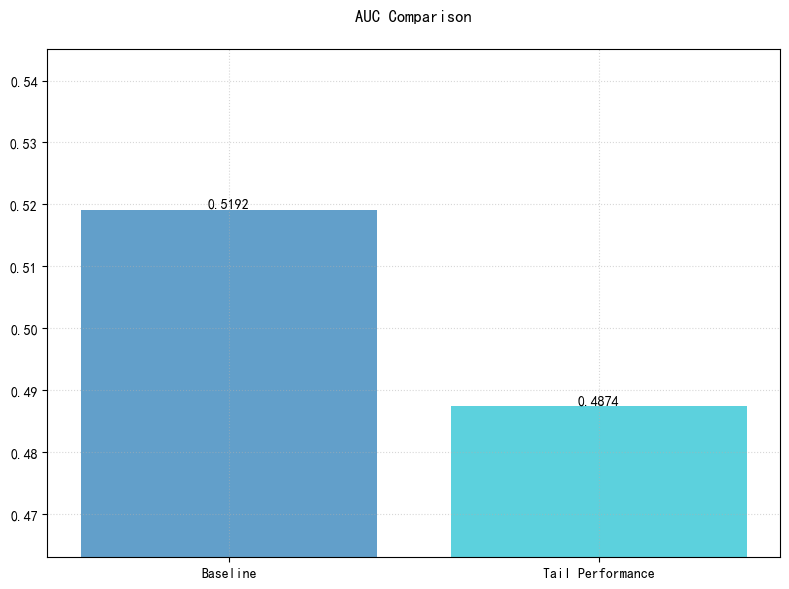

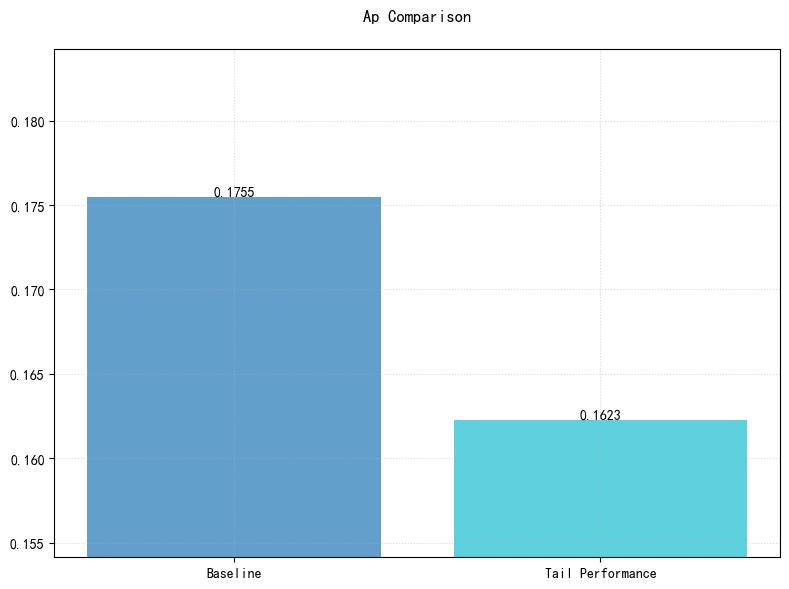

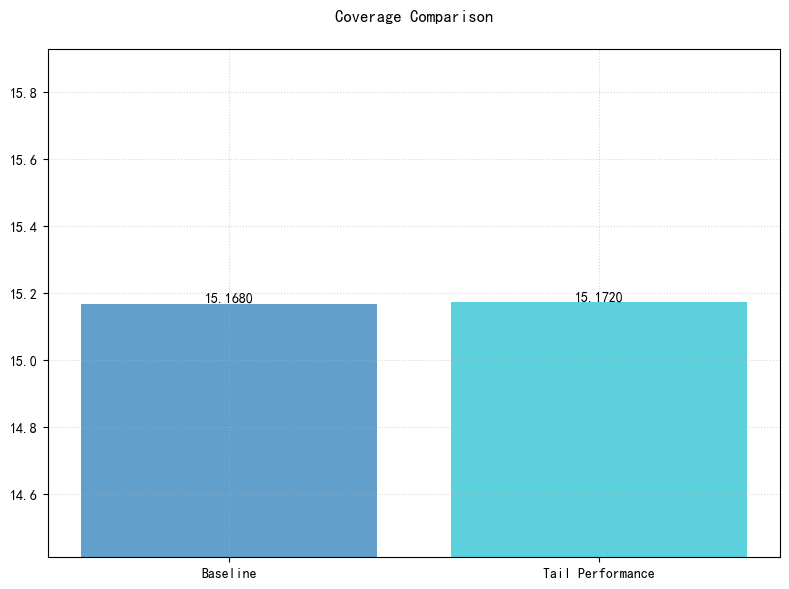

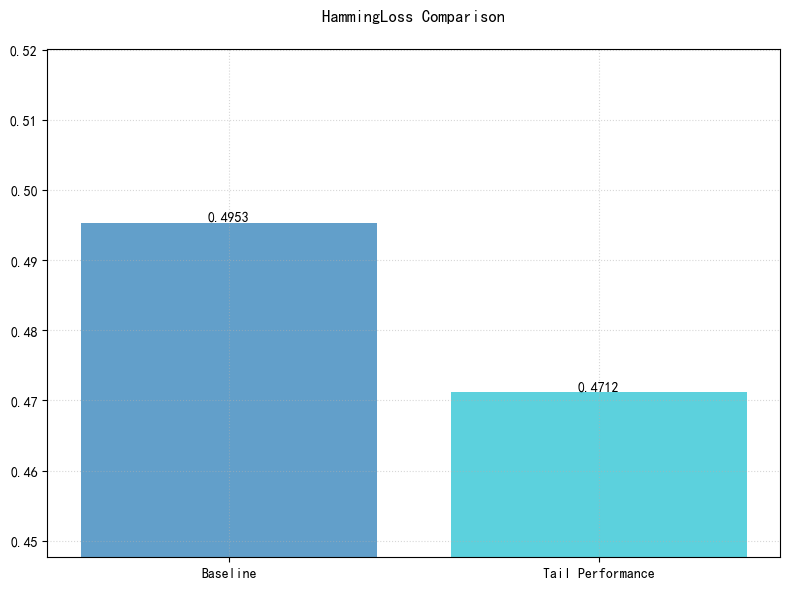

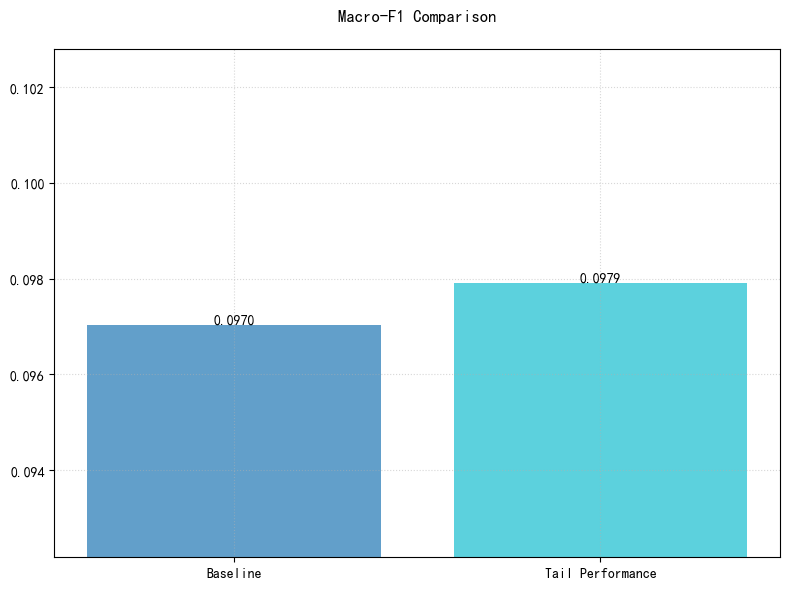

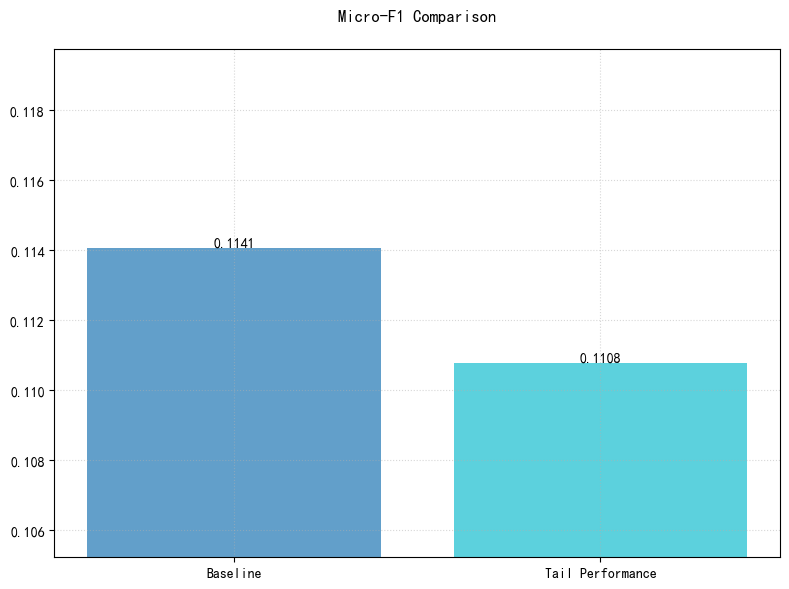

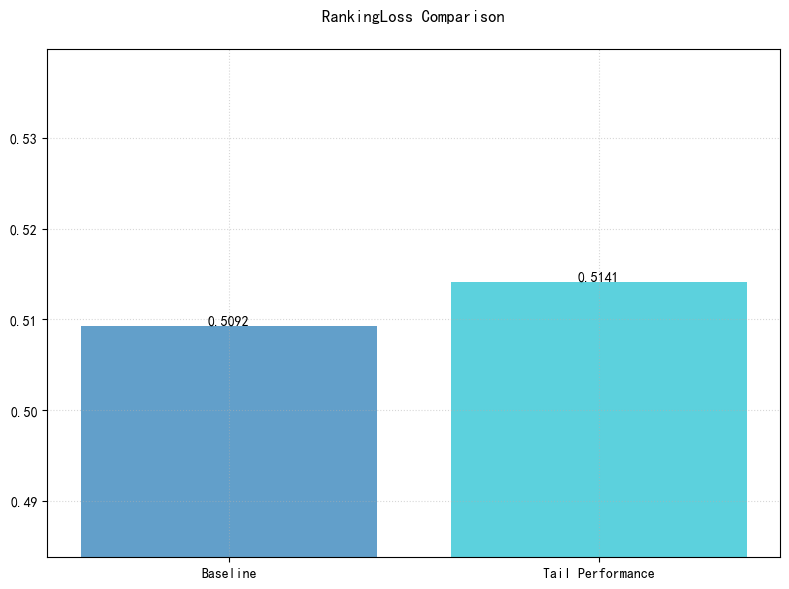

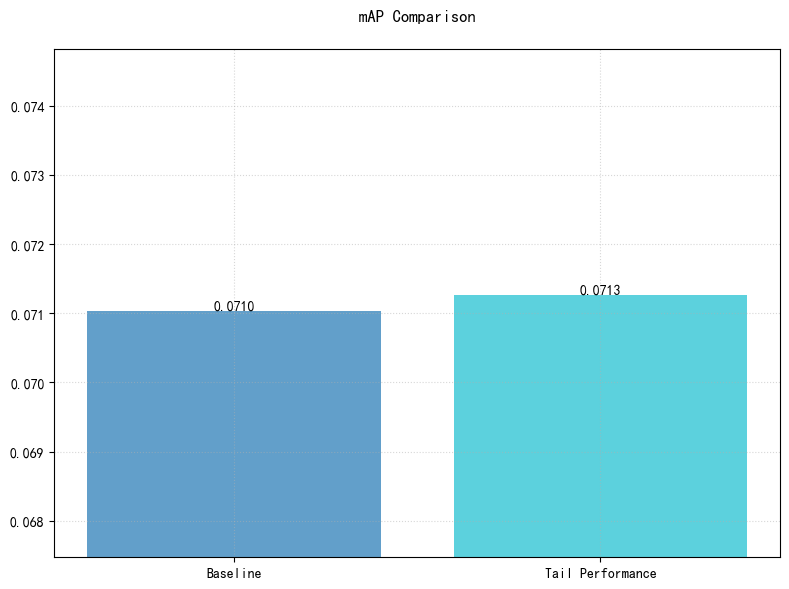

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

def plot_metrics_separately(metrics_dict, fig_width=8):
    """独立生成每个指标的对比图"""
    metric_names = sorted(metrics_dict[next(iter(metrics_dict))].keys())
    model_names = list(metrics_dict.keys())
    colors = plt.cm.tab10(np.linspace(0,1,len(model_names)))
    
    for metric in metric_names:
        plt.figure(figsize=(fig_width,6))
        values = [metrics_dict[name][metric] for name in model_names]
        
        # 动态调整Y轴范围
        y_min = min(values)*0.95 if min(values)>0 else min(values)*1.05
        y_max = max(values)*1.05
        
        bars = plt.bar(model_names, values, color=colors, alpha=0.7)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x()+bar.get_width()/2, height, 
                    f'{height:.4f}', ha='center', va='bottom')
        
        plt.title(f'{metric} Comparison')
        plt.ylim(y_min, y_max)
        plt.grid(linestyle=':', alpha=0.5)
        plt.tight_layout()
        plt.show()

def generate_metric_table(metrics_dict):
    """生成可复制的基础DataFrame表格"""
    df = DataFrame.from_dict(metrics_dict, orient='index')
    
    # 添加最佳标记
    best_markers = DataFrame(index=df.index, columns=df.columns, data='')
    for col in df.columns:
        if 'Loss' in col or 'Cvg' in col:
            best_idx = df[col].idxmin()
        else:
            best_idx = df[col].idxmax()
        best_markers.loc[best_idx, col] = '★'
    
    return df.round(4), best_markers

def print_text_table(metrics_dict):
    """生成纯文本格式的可复制表格"""
    df, markers = generate_metric_table(metrics_dict)
    
    # 构建表头
    header = "Model".ljust(12) + "|"
    for col in df.columns:
        header += f" {col[:8]:<8}|"
    print("-"*len(header))
    print(header)
    print("-"*len(header))
    
    # 填充数据行
    for model in df.index:
        row = f"{model:<12}|"
        for col in df.columns:
            val = f"{df.loc[model, col]:.4f}"
            if markers.loc[model, col]:
                val = f"{val}★" 
            row += f" {val:<8}|"
        print(row)
    print("-"*len(header))


plot_metrics_separately2({
        'Baseline': {'Coverage': 15.168, 'AUC': 0.5191622978966972, 'Ap': 0.17547403392657482, 'mAP': 0.07102588910230385, 'RankingLoss': 0.5092281301821748, 'HammingLoss': 0.4953461538461538, 'Micro-F1': 0.11405379376762742, 'Macro-F1': 0.097027076558962},
        'Tail Performance': tail_metrics
    })

# 1. 生成独立图表
# plot_metrics_separately2(metrics_data)
metrics_data = {
    '未采样数据': {'Coverage': 15.168, 'AUC': 0.5191622978966972, 'Ap': 0.17547403392657482, 'mAP': 0.07102588910230385, 'RankingLoss': 0.5092281301821748, 'HammingLoss': 0.4953461538461538, 'Micro-F1': 0.11405379376762742, 'Macro-F1': 0.097027076558962},
    '采样数据': tail_metrics
}


In [84]:
# 2. 生成可复制表格
df_table, best_markers = generate_metric_table(metrics_data)
print("\n基础DataFrame表格:")
print(df_table)

print("\n带标记的文本表格:")
print_text_table(metrics_data)


基础DataFrame表格:
       Coverage     AUC      Ap     mAP  RankingLoss  HammingLoss  Micro-F1  \
未采样数据    15.168  0.5192  0.1755  0.0710       0.5092       0.4953    0.1141   
采样数据     15.172  0.4874  0.1623  0.0713       0.5141       0.4712    0.1108   

       Macro-F1  Tail_mAP  
未采样数据    0.0970       NaN  
采样数据     0.0979       NaN  

带标记的文本表格:
-------------------------------------------------------------------------------------------------------
Model       | Coverage| AUC     | Ap      | mAP     | RankingL| HammingL| Micro-F1| Macro-F1| Tail_mAP|
-------------------------------------------------------------------------------------------------------
未采样数据       | 15.1680 | 0.5192★ | 0.1755★ | 0.0710  | 0.5092★ | 0.4953  | 0.1141★ | 0.0970  | nan     |
采样数据        | 15.1720★| 0.4874  | 0.1623  | 0.0713★ | 0.5141  | 0.4712★ | 0.1108  | 0.0979★ | nan     |
-------------------------------------------------------------------------------------------------------
